In [64]:
# 验证路径设置
%matplotlib inline
import os
import sys
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display


# 自动计算项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))  
if project_root not in sys.path:
    sys.path.insert(0, project_root)

    
# 打印当前环境路径
print(f"Python executable: {sys.executable}")
print(f"Project root: {project_root}")
# 导入模块

try:
    from config.tickers import NASDAQ_100
    from config.NASDAQ_100_Chinese  import NASDAQ_100_Chinese
    from importnb import Notebook
    from openai import OpenAI 
    from dotenv import load_dotenv
    from IPython import get_ipython
    load_dotenv()  # 自动加载.env文件
    with Notebook():
        from src.visualization import plot_technical
        from src.downloader import download_stock_data
    print("✅ 模块导入成功！")
except ImportError as e:
    print(f"❌ 导入失败: {str(e)}")
    print("当前 Python 路径：", sys.path)


Python executable: c:\Users\theli\Documents\GitHub\stock_project\.venv\Scripts\python.exe
Project root: c:\Users\theli\Documents\GitHub\stock_project
✅ 模块导入成功！


In [65]:
# 下载股票数据
start_date = '2025-10-01'
end_date = '2025-12-31'
period = '3mo'
interval = '1h'
ticker = ['MARA']

df = download_stock_data( ticker , start_date , end_date , period=period, interval=interval)
df.head()

[*********************100%***********************]  1 of 1 completed
c:\Users\theli\Documents\GitHub\stock_project\src\downloader.ipynb:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'] = df['Volume'].replace(0, np.nan).fillna(method='ffill')  # 处理成交量为0的情况


,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI
Datetime,,,,,,,,,,,,
2025-08-12 15:30:00+00:00,15.8400,15.920,15.780,15.780,NaN,NaN,NaN,0.887201,NaN,NaN,NaN,NaN
2025-08-12 16:30:00+00:00,15.7900,15.810,15.650,15.661,4504648.0,-0.754116,-0.007570,1.022369,NaN,NaN,NaN,NaN
2025-08-12 17:30:00+00:00,15.6649,15.710,15.570,15.670,2791660.0,0.057466,0.000574,0.899167,NaN,NaN,NaN,NaN
2025-08-12 18:30:00+00:00,15.6650,15.735,15.615,15.725,2310808.0,0.350991,0.003504,0.768491,NaN,NaN,NaN,NaN
2025-08-12 19:30:00+00:00,15.7299,15.850,15.700,15.720,2883562.0,-0.031797,-0.000318,0.955418,NaN,NaN,NaN,NaN


c:\Users\theli\Documents\GitHub\stock_project\src\visualization.ipynb:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 0.1)


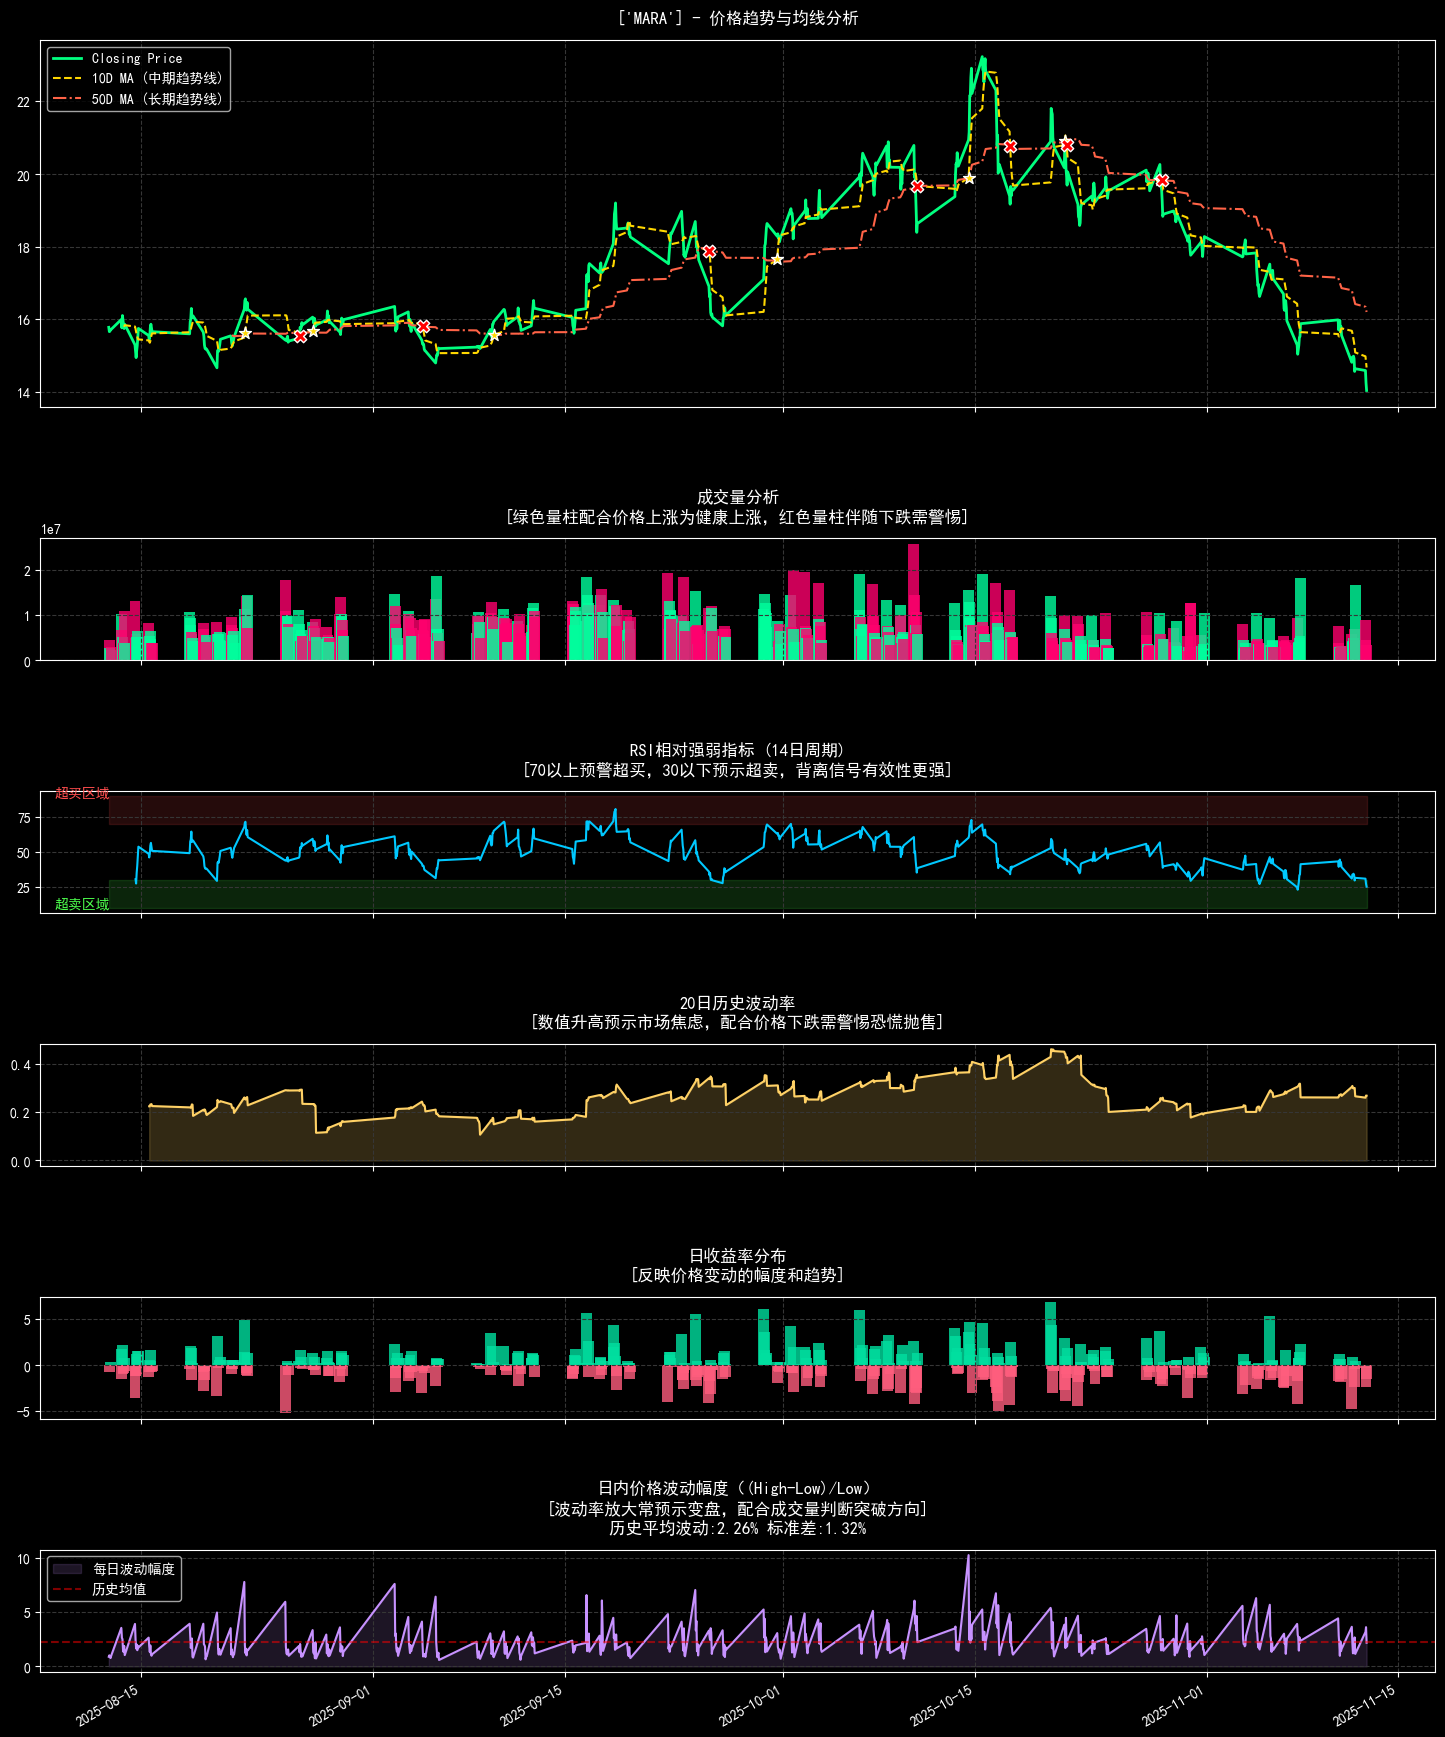

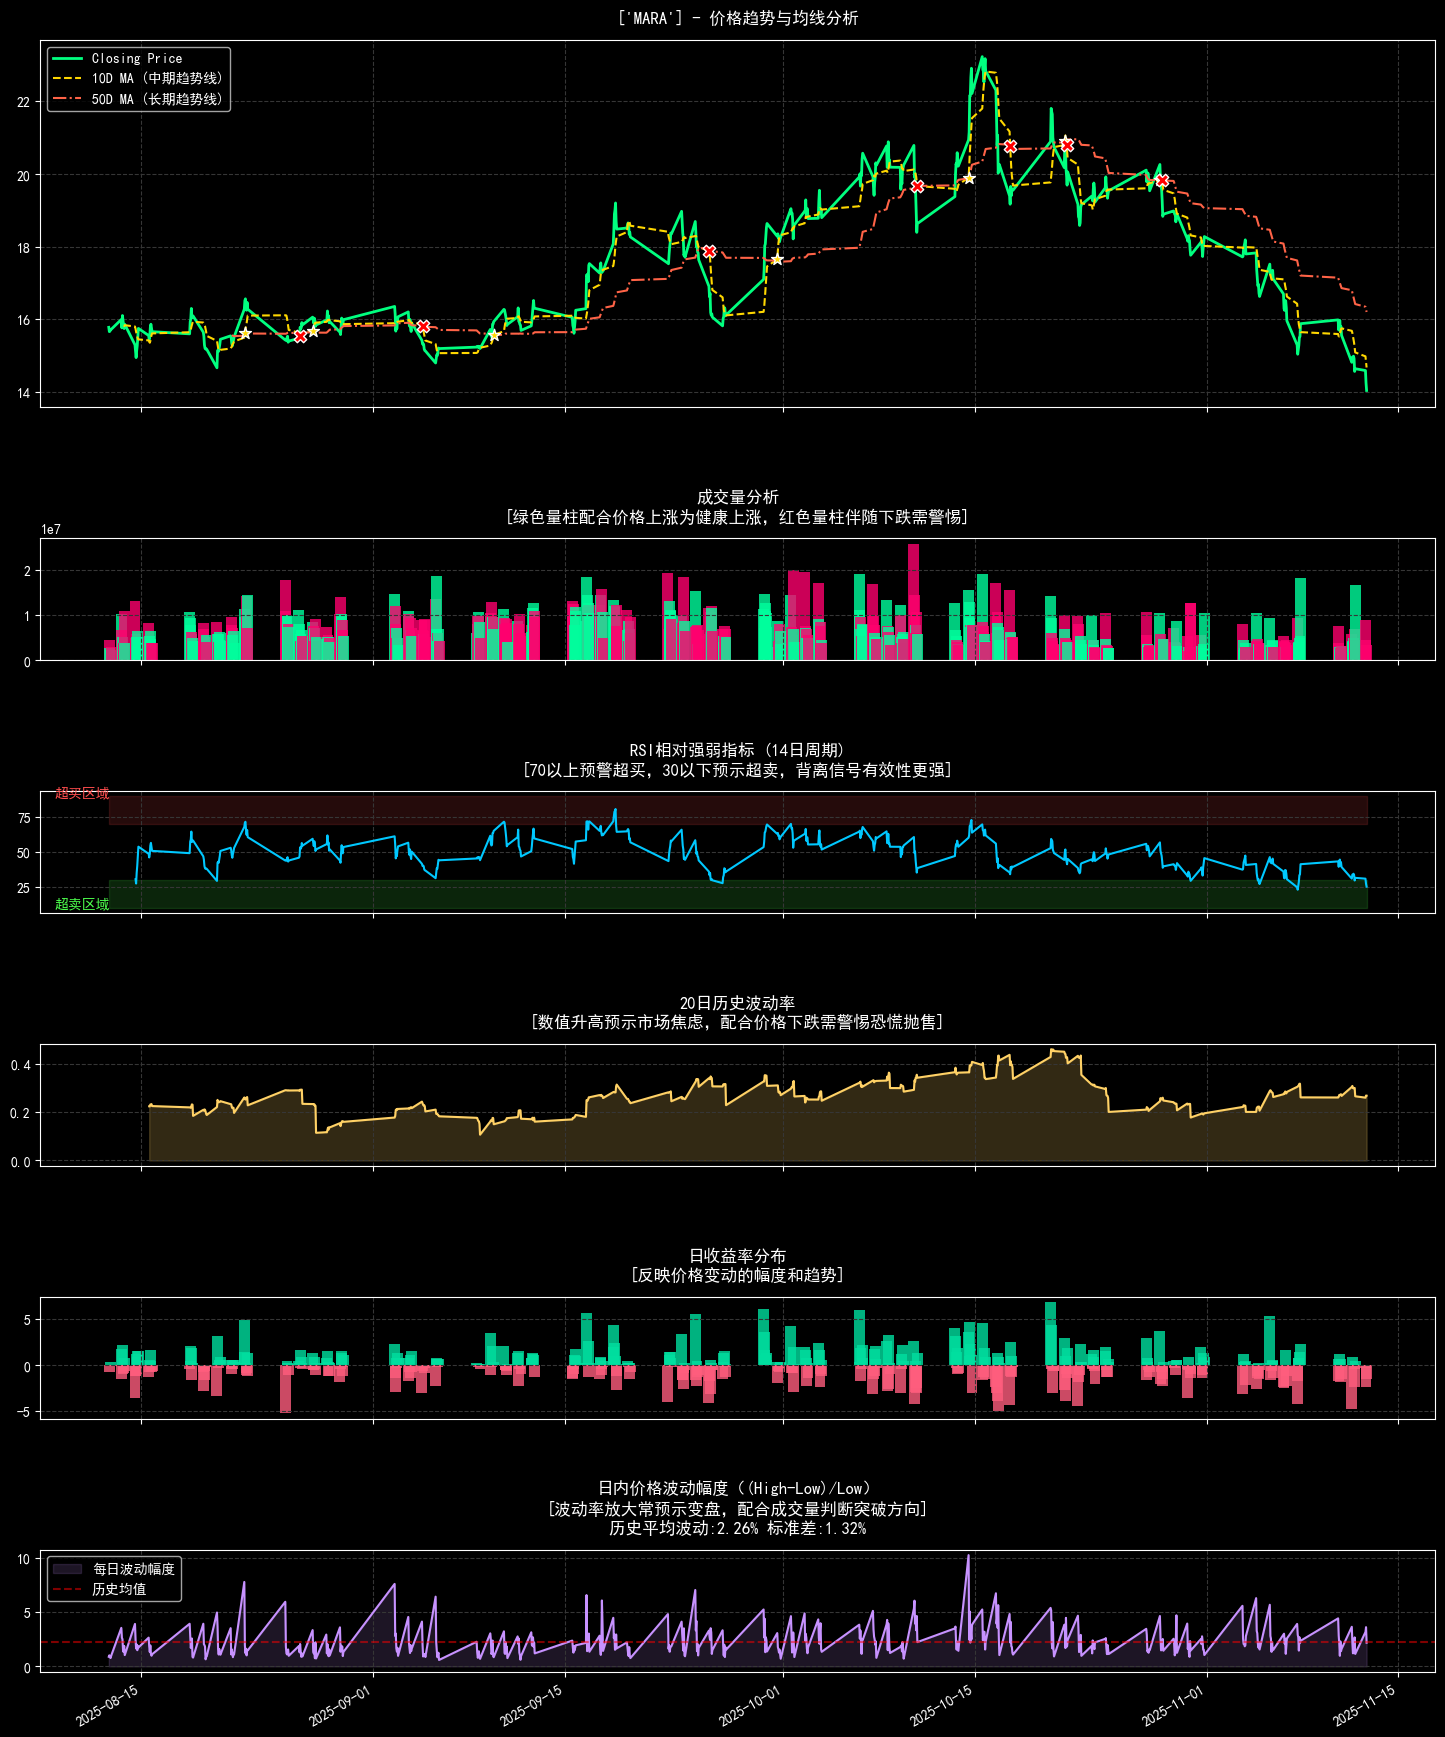

In [66]:
plot_technical(df,ticker)

In [67]:
def get_deepseek_analysis(df, model="deepseek-r1-250120"):
    """
    智能生成股票技术面分析报告和预测未来趋势
    输入：预处理后的美股数据
    输出：deepseek的回答，不包含思考过程
    """
    
    from dotenv import load_dotenv
    load_dotenv()
    # 1、股票数据
    latest = df
        # 提取元数据
    start_date = df.index.min()
    end_date = df.index.max()

    # 生成数据摘要
    data_summary = f"""
    收盘价范围：${df['Close'].min():.2f} - ${df['Close'].max():.2f}
    平均成交量：{df['Volume'].mean():,.0f} 手
    近期波动率：{df['Close'].pct_change().std():.2%}（过去20日）
    """
    
    # 步骤2：构建专业分析提示词
    analysis_prompt = f"""你是美股投资专家，这是{ticker}从{start_date}到{end_date}的交易数据，
    请用简单专业的语言分析{ticker[0]}的走势及其多/空投资机会：
    {latest}
    """
    
    # 步骤3：调用Deepseek API并解析结果
    # try:
    notebook_path = get_ipython().config["IPKernelApp"]["connection_file"].split("\\")[-2]
    project_root = Path(notebook_path).resolve().parent.parent# 动态构建项目路径 
    client = OpenAI(
            api_key='sk-svlwkvpmiesxltcrmogahgwdpsucauiqdvdrgssmogbtujvh',
            base_url='https://api.siliconflow.cn/v1'
            )
    
    completion = client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=[
            {"role": "user", "content": analysis_prompt}
        ],
        max_tokens = 8192,
        temperature = 0.3
    )
    # 解析响应
    response_message = completion.choices[0].message

    # 提取回答和思考内容
    answer = response_message.content
    reasoning = response_message.reasoning_content

    # 格式化输出，只显示回答，不显示思考
    formatted_output = f'{answer.strip()}'

    output_file = "temp_output.md"
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("# DeepSeek 分析报告\n\n")
        f.write("## 数据摘要\n")
        f.write(data_summary + "\n\n")
        f.write("## 分析结果\n")
        f.write(formatted_output + "\n")
    os.system(f'code {output_file}')  # 在默认Markdown查看器中打开文件
    
    return print(data_summary + "\n" + formatted_output)
        
    # except Exception as e:
    #     print(f"模型调用失败: {str(e)}")
    #     return "暂无分析结果"

In [ ]:
get_deepseek_analysis(df)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MA10_above_MA50
Datetime,,,,,,,,,,,,,
2025-08-12 15:30:00+00:00,62.400002,66.000000,60.770000,61.130001,NaN,NaN,NaN,8.606219,NaN,NaN,NaN,NaN,False
2025-08-12 16:30:00+00:00,61.084999,65.349998,60.990002,63.959999,10123718.0,4.629475,0.045255,7.148707,NaN,NaN,NaN,NaN,False
2025-08-12 17:30:00+00:00,63.926399,66.879997,63.599998,65.140099,10746509.0,1.845059,0.018282,5.157231,NaN,NaN,NaN,NaN,False
2025-08-12 18:30:00+00:00,65.190002,67.586800,62.500000,62.799999,11198698.0,-3.592410,-0.036585,8.138879,NaN,NaN,NaN,NaN,False
2025-08-12 19:30:00+00:00,62.820000,63.750000,62.009998,62.240002,5682008.0,-0.891716,-0.008957,2.806002,NaN,NaN,NaN,NaN,False


In [ ]:
def generate_report(ticker,start_date,end_date, period=None):
    import matplotlib.pyplot as plt
    
    df = download_stock_data([ticker], start_date, end_date, period)
    analysis_text = get_deepseek_analysis(df)
    fig = plot_technical(df,ticker)
    
    return plt.show(fig) ,analysis_text


In [ ]:
generate_report(ticker,start_date,end_date, period=period)

TypeError: expected string or bytes-like object, got 'list'